In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
import pickle
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import Huber
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Работа с данными

In [68]:
xl = pd.read_excel('Avito House.xlsx')

In [69]:
df = pd.DataFrame(xl)

In [70]:
df

,Название,Цена,URL,Описание,Просмотров,Дата публикации,Продавец,Адрес
0,"1-к. квартира, 45 м², 3/17 эт.",30000,https://www.avito.ru/rostov-na-donu/kvartiry/1-k._kvartira_45_m_317_et._4608266976,"Очень уютная 1-к квартира от собственника в ЖК Сокол град. Закрытая охраняемая территория, огромная детская площадка во дворе. Квартира новая в ней, практически никто не жил.",170,2025-01-23,Арендодатель,"ростовская обл., ростов-на-дону, пр-т 40-летия победы, 63/17с7\nр-н пролетарский"
1,"1-к. квартира, 38 м², 10/23 эт.",40000,https://www.avito.ru/rostov-na-donu/kvartiry/1-k._kvartira_38_m_1023_et._4392910511,"* от Собственника*. Прекрасная квартира для тех, кто ценит комфорт и красоту. *Уютный интерьер* — эта квартира создана для людей, которые любят себя и окружающую красоту. Здесь гармонично сочетаются стиль и функциональность, что делает её идеальным местом для проживания. *Панорамный балкон* — наслаждайтесь завтраком или вечерним чаем на балконе с потрясающим видом на живописную аллею. *Комфорт в любые времена года* — два кондиционера: в кухне и комнате обеспечат идеальную атмосферу. Индивидуальное отопление гарантирует теплые зимние вечера, при этом расходы на отопление вас приятно удивят. *Функциональные зоны* — квартира предлагает удобные пространства, включая зону отдыха: кровать с ортопедическим матрасом Ikea, где вы сможете расслабиться после долгого дня, и уютную зону с телевизором для приятных вечеров с любимыми фильмами. Максимальная вместимость два человека. *Минимальные коммунальные платежи* — вы сможете наслаждаться комфортом и практичностью, не беспокоясь о высоких счетах. Всё в этой квартире сделано эргономично. *Фотографии квартиры* полностью соответствуют действительности, чтобы вы могли насладиться её уникальным стилем до первого визита. Российское гражданство, прописка РФ. Без детей. Без животных. Запрещено курить. Субаренда.",1583,2025-01-14,Арендодатель,"ростовская обл., ростов-на-дону, берберовская ул., 16с2\nр-н пролетарский"
2,"Квартира-студия, 42 м², 3/10 эт.",25000,https://www.avito.ru/rostov-na-donu/kvartiry/kvartira-studiya_42_m_310_et._4727843608,При встрече расскажу.,430,2025-01-21,Арендодатель,"ростовская обл., ростов-на-дону, ул. 2-й пятилетки, 6\nр-н октябрьский"
3,"2-к. квартира, 65 м², 7/9 эт.",37000,https://www.avito.ru/rostov-na-donu/kvartiry/2-k._kvartira_65_m_79_et._2228490799,"Объявление реальное, я собственник. Сдаётся двухкомнатная уютная квартира в элитном ЖК «Голубые ели». Дома в комплексе 9 этажей. Охраняемая закрытая территория, видеонаблюдение, консьерж, собственная парковка. Детские и спортивные площадки, зоны отдыха, магазины, парикмахерские, спортивный центр, дет. Сады и т. Д. В шаговой доступности школы, общественный транспорт и вся инфраструктура. В квартире есть всё необходимое для жизни -мебель и бытовая техника. Просторная лоджия, окна выходят во двор. Собственник, без посредников.",3060,2025-01-20,Арендодатель,"ростовская обл., ростов-на-дону, пр-т 40-летия победы, 13/9\nр-н пролетарский"
4,"2-к. квартира, 68 м², 7/10 эт.",35000,https://www.avito.ru/rostov-na-donu/kvartiry/2-k._kvartira_68_m_710_et._3816284415,Заходите и живите.,334,2025-01-18,Арендодатель,"ростовская обл., ростов-на-дону, ул. миронова, 14а\nр-н первомайский"
...,...,...,...,...,...,...,...,...
739,"2-к. квартира, 50 м², 2/2 эт.",35000,https://www.avito.ru/rostov-na-donu/kvartiry/2-k._kvartira_50_m_22_et._3513447963?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,"Сдам тёплую, уютную квартиру в историческом центре города аккуратными и платёже способным людям. В пешей доступности центральный рынок, медицинские и учебные заведения, магазины и набережная. Удобная транспортная развязка городских автобусов и трамваев.",268,2025-01-26,Арендодатель,"ростовская обл., ростов-на-дону, ул. баумана, 35а\nр-н ленинский"
740,"1-к. квартира, 52 м², 11/24 эт.",38000,https://www.avito.ru/rostov-na-donu/kvartiry/1-k._kvartira_52_m_1124_et._4582523363?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Название         744 non-null    object        
 1   Цена             744 non-null    int64         
 2   URL              744 non-null    object        
 3   Описание         744 non-null    object        
 4   Просмотров       744 non-null    int64         
 5   Дата публикации  744 non-null    datetime64[ns]
 6   Продавец         744 non-null    object        
 7   Адрес            744 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 46.6+ KB


In [72]:
#Добавляем столбец Площадь с данными о ней
df ['Площадь'] = df['Название'].str.extract(r'(\d+)\s*м²')[0].astype('int32')

In [73]:
#Добавляем столбец Кол-во комнат с данными о ней
df['Количество комнат'] = df['Название'].str[0]

In [74]:
#Изменяем данные в 'Количество комнат' где К на 0 - это студии
df.loc[df['Количество комнат'] == 'К', 'Количество комнат'] = 0

In [75]:
# Преобразовываем в числовой тип
df["Количество комнат"] = df['Количество комнат'].astype('int32')

In [76]:
df['Количество комнат'].unique()

array([1, 0, 2, 4, 3], dtype=int32)

In [77]:
# Добавляем столбец этаж с данными о ней
df['Этаж'] = df['Название'].str.extract(r'\b(\d+)/').astype('int32')

In [78]:
# Добавляем столбец Всего этажей с данными о ней
df['Всего этажей'] = df['Название'].str.extract(r'\b/(\d+)').astype('int32')

In [79]:
df.head(5)

,Название,Цена,URL,Описание,Просмотров,Дата публикации,Продавец,Адрес,Площадь,Количество комнат,Этаж,Всего этажей
0,"1-к. квартира, 45 м², 3/17 эт.",30000,https://www.avito.ru/rostov-na-donu/kvartiry/1-k._kvartira_45_m_317_et._4608266976,"Очень уютная 1-к квартира от собственника в ЖК Сокол град. Закрытая охраняемая территория, огромная детская площадка во дворе. Квартира новая в ней, практически никто не жил.",170,2025-01-23,Арендодатель,"ростовская обл., ростов-на-дону, пр-т 40-летия победы, 63/17с7\nр-н пролетарский",45,1,3,17
1,"1-к. квартира, 38 м², 10/23 эт.",40000,https://www.avito.ru/rostov-na-donu/kvartiry/1-k._kvartira_38_m_1023_et._4392910511,"* от Собственника*. Прекрасная квартира для тех, кто ценит комфорт и красоту. *Уютный интерьер* — эта квартира создана для людей, которые любят себя и окружающую красоту. Здесь гармонично сочетаются стиль и функциональность, что делает её идеальным местом для проживания. *Панорамный балкон* — наслаждайтесь завтраком или вечерним чаем на балконе с потрясающим видом на живописную аллею. *Комфорт в любые времена года* — два кондиционера: в кухне и комнате обеспечат идеальную атмосферу. Индивидуальное отопление гарантирует теплые зимние вечера, при этом расходы на отопление вас приятно удивят. *Функциональные зоны* — квартира предлагает удобные пространства, включая зону отдыха: кровать с ортопедическим матрасом Ikea, где вы сможете расслабиться после долгого дня, и уютную зону с телевизором для приятных вечеров с любимыми фильмами. Максимальная вместимость два человека. *Минимальные коммунальные платежи* — вы сможете наслаждаться комфортом и практичностью, не беспокоясь о высоких счетах. Всё в этой квартире сделано эргономично. *Фотографии квартиры* полностью соответствуют действительности, чтобы вы могли насладиться её уникальным стилем до первого визита. Российское гражданство, прописка РФ. Без детей. Без животных. Запрещено курить. Субаренда.",1583,2025-01-14,Арендодатель,"ростовская обл., ростов-на-дону, берберовская ул., 16с2\nр-н пролетарский",38,1,10,23
2,"Квартира-студия, 42 м², 3/10 эт.",25000,https://www.avito.ru/rostov-na-donu/kvartiry/kvartira-studiya_42_m_310_et._4727843608,При встрече расскажу.,430,2025-01-21,Арендодатель,"ростовская обл., ростов-на-дону, ул. 2-й пятилетки, 6\nр-н октябрьский",42,0,3,10
3,"2-к. квартира, 65 м², 7/9 эт.",37000,https://www.avito.ru/rostov-na-donu/kvartiry/2-k._kvartira_65_m_79_et._2228490799,"Объявление реальное, я собственник. Сдаётся двухкомнатная уютная квартира в элитном ЖК «Голубые ели». Дома в комплексе 9 этажей. Охраняемая закрытая территория, видеонаблюдение, консьерж, собственная парковка. Детские и спортивные площадки, зоны отдыха, магазины, парикмахерские, спортивный центр, дет. Сады и т. Д. В шаговой доступности школы, общественный транспорт и вся инфраструктура. В квартире есть всё необходимое для жизни -мебель и бытовая техника. Просторная лоджия, окна выходят во двор. Собственник, без посредников.",3060,2025-01-20,Арендодатель,"ростовская обл., ростов-на-дону, пр-т 40-летия победы, 13/9\nр-н пролетарский",65,2,7,9
4,"2-к. квартира, 68 м², 7/10 эт.",35000,https://www.avito.ru/rostov-na-donu/kvartiry/2-k._kvartira_68_m_710_et._3816284415,Заходите и живите.,334,2025-01-18,Арендодатель,"ростовская обл., ростов-на-дону, ул. миронова, 14а\nр-н первомайский",68,2,7,10


In [80]:
#Преобразовываем типы данных 
df['Продавец'] = df['Продавец'].astype('category')

In [81]:
#Cоздаем новый столбец с типом квартиры
df['Тип'] = df['Количество комнат'].map({0: 'Студия', 1 : 'Квартира', 2 : 'Квартира', 3 : 'Квартира', 4 : 'Квартира'}).astype('category')

In [82]:
pd.options.display.max_colwidth = None
df['Адрес'][100:130]

100                                   ростовская обл., ростов-на-дону, ул. серафимовича, 37\nр-н ленинский
101                                ростовская обл., ростов-на-дону, пер. поленова, 21/10\nр-н первомайский
102                                         ростовская обл., ростов-на-дону, ул. седова, 63\nр-н кировский
103                                   ростовская обл., ростов-на-дону, пер. белоусова, 20\nр-н октябрьский
104                                  ростовская обл., ростов-на-дону, пр-т шолохова, 264\nр-н первомайский
105                                      ростовская обл., ростов-на-дону, ул. ерёменко, 112\nр-н советский
106               ростовская обл., ростов-на-дону, мкр-н северный, пр-т космонавтов, 20\nр-н ворошиловский
107                            ростовская обл., ростов-на-дону, ул. петрашевского, 36\nр-н железнодорожный
108                                        ростовская обл., ростов-на-дону, ул. зорге, 56/2\nр-н советский
109                           ростовс

In [83]:
#Создаем столбец улица 
df['Улица'] = df['Адрес'].str.extract(r'((?:пр-т|пл.?|ул\.?|пер\.?|б-р)\s[^\n,]+|[^\n,]+\s(?:пр-т|пл.?|ул\.?|пер\.?|б-р))')

In [84]:
#Проверяем новый столбец на null
pd.options.display.max_colwidth = None
df[df['Улица'].isna()][['Адрес','Улица']]

,Адрес,Улица
421,"ростовская обл., ростов-на-дону, кировский район\nр-н кировский",NaN
457,"ростовская обл., ростов-на-дону, кировский район, жилой комплекс ростов-сити\nр-н кировский",NaN


In [85]:
# Заменяем в ручную nan значения
df['Улица'].iloc[421] = 'Unknown'
df['Улица'].iloc[457] = 'ул. Суворова'

C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\613182292.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Улица'].iloc[421] = 'Unknown'
C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\613182292.py:2: SettingWithCopyWarning:

In [86]:
# Cоздаем столбец номера домов
df['Номер дома'] = df['Адрес'].str.extract(r'(\d+(?:/\d+)*[а-яА-Я\d]*)')


In [87]:
#Проверяем Номер дома столбец на null
df[df['Номер дома'].isna()][['Адрес','Номер дома']]

,Адрес,Номер дома
375,"ростовская обл., ростов-на-дону, халтуринский пер.\nр-н ленинский",NaN
421,"ростовская обл., ростов-на-дону, кировский район\nр-н кировский",NaN
451,"ростовская обл., ростов-на-дону, большая садовая ул.\nр-н ленинский",NaN
457,"ростовская обл., ростов-на-дону, кировский район, жилой комплекс ростов-сити\nр-н кировский",NaN


In [88]:
# Заменяем в ручную nan значения
df['Номер дома'].iloc[457] = 91
df['Номер дома'].fillna('Unknown', inplace=True)

C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\1636728407.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Номер дома'].iloc[457] = 91
C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\1636728407.py:2: SettingWithCopyWarning:

In [89]:
# Cоздаем столбец район
df['Район'] = df['Адрес'].str.extract(r'р-н\s([а-яА-Я\s]+)')

In [90]:
df['Район'].unique()

array(['пролетарский', 'октябрьский', 'первомайский', 'ленинский',
       'кировский', 'железнодорожный', 'северный', 'советский',
       'ленгородок', 'западный', 'сельмаш', 'ворошиловский',
       'новое поселение', 'темерник', 'мясникован', 'болгарстрой',
       'берберовка', 'каменка'], dtype=object)

In [91]:
#Проверяем Район столбец на null
df[df['Район'].isna()][['Адрес','Номер дома']]

,Адрес,Номер дома


In [92]:
#Удаляем не нужные столбцы 
df.drop(columns=['Описание', 'Название', 'URL', 'Адрес'], inplace=True)

In [93]:
#Преобразовываем типы данных 
df['Район'] = df['Район'].astype('category')
df['Улица'] = df['Улица'].astype('string')
df['Номер дома'] = df['Номер дома'].astype('string')

In [94]:
#Преобразовываем данные к одному виду. Чтобы ул. была в начали 
df['Улица'] = df['Улица'].str.replace(r'(\S+)\sпер\.$', r'пер. \1', regex=True)
df['Улица'] = df['Улица'].str.replace(r'(\S+)\sул\.$', r'ул. \1', regex=True)
df['Улица'] = df['Улица'].str.replace(r'(\S+)\sб-р\.$', r'б-р. \1', regex=True)
df['Улица'] = df['Улица'].str.replace(r'(\S+)\sпл\.$', r'пл. \1', regex=True)
df['Улица'] = df['Улица'].str.replace(r'(\S+)\sпр-т\.$', r'пр-т. \1', regex=True)

In [95]:
#Ставим . в конце сокращений
df['Улица'] = df['Улица'].str.replace(r'\bпер\s(?!\.)', r'пер. ', regex=True)
df['Улица'] = df['Улица'].str.replace(r'\bул\s(?!\.)', r'ул. ', regex=True)
df['Улица'] = df['Улица'].str.replace(r'\bпл\s(?!\.)', r'пл. ', regex=True)
df['Улица'] = df['Улица'].str.replace(r'\bпр-т\s(?!\.)', r'пр-т. ', regex=True)
df['Улица'] = df['Улица'].str.replace(r'\bб-р\s(?!\.)', r'б-р. ', regex=True)

#пр-т без . перобразовываем в пр-т. И б-р.
df['Улица'] = df['Улица'].str.replace(r'(\S+)\sпр-т$', r'пр-т. \1', regex=True)
df['Улица'] = df['Улица'].str.replace(r'(\S+)\sб-р$', r'б-р. \1', regex=True)

In [96]:
#Перемещаем из середины в начало
df['Улица'] = df['Улица'].str.replace(r'(\S+)\sул\.\s(\S+)', r'ул. \1 \2', regex=True)
df['Улица'] = df['Улица'].str.replace(r'(\S+)\sпер\.\s(\S+)', r'пер. \1 \2', regex=True)

In [97]:
#Проверяем что все строки соответствуют данному условию. 
#Просмотр строк, не начинающихся с указанных аббревиатур с точкой
df[~df['Улица'].str.contains(r'^пер\.|^ул\.|^пл\.|^пр-т\.|^б-р\.')]

,Цена,Просмотров,Дата публикации,Продавец,Площадь,Количество комнат,Этаж,Всего этажей,Тип,Улица,Номер дома,Район
1,40000,1583,2025-01-14,Арендодатель,38,1,10,23,Квартира,ул. берберовская,16с2,пролетарский
6,38000,1963,2025-01-21,Агентство,36,1,7,26,Квартира,пер. соборный,98,октябрьский
7,45000,130,2025-01-23,Агентство,75,2,7,10,Квартира,ул. искусственная,4,пролетарский
8,35000,982,2025-01-23,Агентство,32,1,15,24,Квартира,ул. берберовская,30,пролетарский
9,30000,924,2025-01-21,Арендодатель,33,0,2,4,Студия,пер. педагогический,6,октябрьский
...,...,...,...,...,...,...,...,...,...,...,...,...
734,26000,489,2025-01-20,Арендодатель,42,1,17,17,Квартира,ул. стабильная,21,советский
737,20000,10,2025-01-26,Риелтор,40,1,10,10,Квартира,пер. днепровский,116в,первомайский
740,38000,24,2025-01-26,Арендодатель,52,1,11,24,Квартира,ул. берберовская,28с1,пролетарский
742,25000,283,2025-01-26,Арендодатель,34,1,2,8,Квартира,б-р. пла,20/17,железнодорожный


In [98]:
#Убираем пробелы в начале 
df['Улица'] = df['Улица'].str.replace(r'^\s+', '', regex=True)

In [99]:
df['Улица'].str.contains(r'^Unk|^пер\.|^ул\.|^пл\.|^пр-т\.|^б-р\.').sum()

np.int64(744)

In [100]:
df[df.duplicated()]

,Цена,Просмотров,Дата публикации,Продавец,Площадь,Количество комнат,Этаж,Всего этажей,Тип,Улица,Номер дома,Район


In [101]:
df.drop(index=98, inplace=True)

In [102]:
df.drop(df[df['Площадь'] == 120].index, inplace=True)

### Визуализация

In [103]:
#Статистика числовых данных
df.describe()

,Цена,Просмотров,Дата публикации,Площадь,Количество комнат,Этаж,Всего этажей
count,740.000000,740.000000,740,740.000000,740.000000,740.000000,740.000000
mean,28315.782432,1131.471622,2024-11-18 16:09:04.864864768,39.205405,1.255405,7.156757,13.687838
min,12000.000000,0.000000,1900-01-19 00:00:00,1.000000,0.000000,1.000000,1.000000
25%,22000.000000,220.500000,2025-01-16 00:00:00,30.000000,1.000000,3.000000,8.000000
50%,26000.000000,539.500000,2025-01-20 00:00:00,38.000000,1.000000,5.000000,14.000000
75%,32000.000000,1265.250000,2025-01-24 00:00:00,47.250000,2.000000,10.000000,19.000000
max,170000.000000,16138.000000,2025-01-26 00:00:00,110.000000,4.000000,26.000000,27.000000
std,11397.991445,1804.040596,NaN,16.654605,0.818203,5.344153,7.190515


In [104]:
#Статистика числовых данных с фильтром по районам(первомайский', 'сельмаш) и типу жилья(Студия) 
df[(df['Район'].isin(['первомайский', 'сельмаш'])) & (df['Тип'] == 'Студия')].describe()


,Цена,Просмотров,Дата публикации,Площадь,Количество комнат,Этаж,Всего этажей
count,13.000000,13.000000,13,13.000000,13.0,13.000000,13.000000
mean,19076.923077,1346.923077,2025-01-17 18:27:41.538461440,27.076923,0.0,7.461538,13.076923
min,13000.000000,60.000000,2025-01-09 00:00:00,21.000000,0.0,1.000000,1.000000
25%,17000.000000,352.000000,2025-01-14 00:00:00,25.000000,0.0,4.000000,6.000000
50%,18000.000000,956.000000,2025-01-19 00:00:00,27.000000,0.0,6.000000,16.000000
75%,23000.000000,1587.000000,2025-01-20 00:00:00,30.000000,0.0,10.000000,18.000000
max,25000.000000,4309.000000,2025-01-26 00:00:00,34.000000,0.0,24.000000,24.000000
std,4091.893174,1287.476243,NaN,3.684688,0.0,6.514284,7.878891


In [105]:
#Копируем датафрейм для удобства работы в дальнейшем
df_Rostov = df.copy()

In [106]:
#Преобразовываем каиегории в численные форматы
df_Rostov['Продавец'] = df_Rostov['Продавец'].map({'Агентство' : 0, 'Риелтор' : 0, 'Арендодатель': 1})
df_Rostov['Тип'] = df_Rostov['Тип'].map({'Квартира': 1, 'Студия': 0})

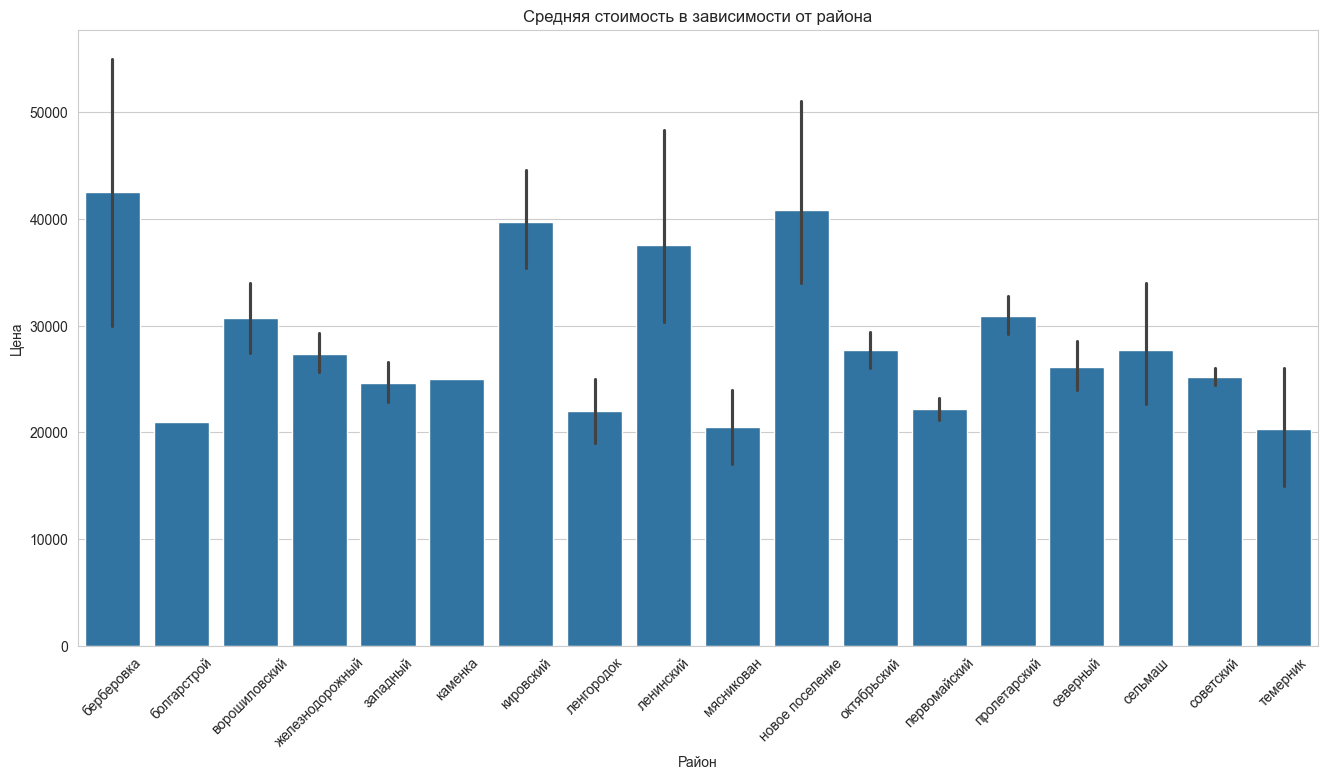

In [107]:
#График средней стоимости цены по районам
plt.figure(figsize=(16,8))
sns.barplot(data=df_Rostov, x = 'Район', y = 'Цена', dodge=False)
plt.title('Средняя стоимость в зависимости от района')
plt.xticks(rotation=45)
plt.show()

Text(0.5, 1.0, 'Tепловая карта корреляций')

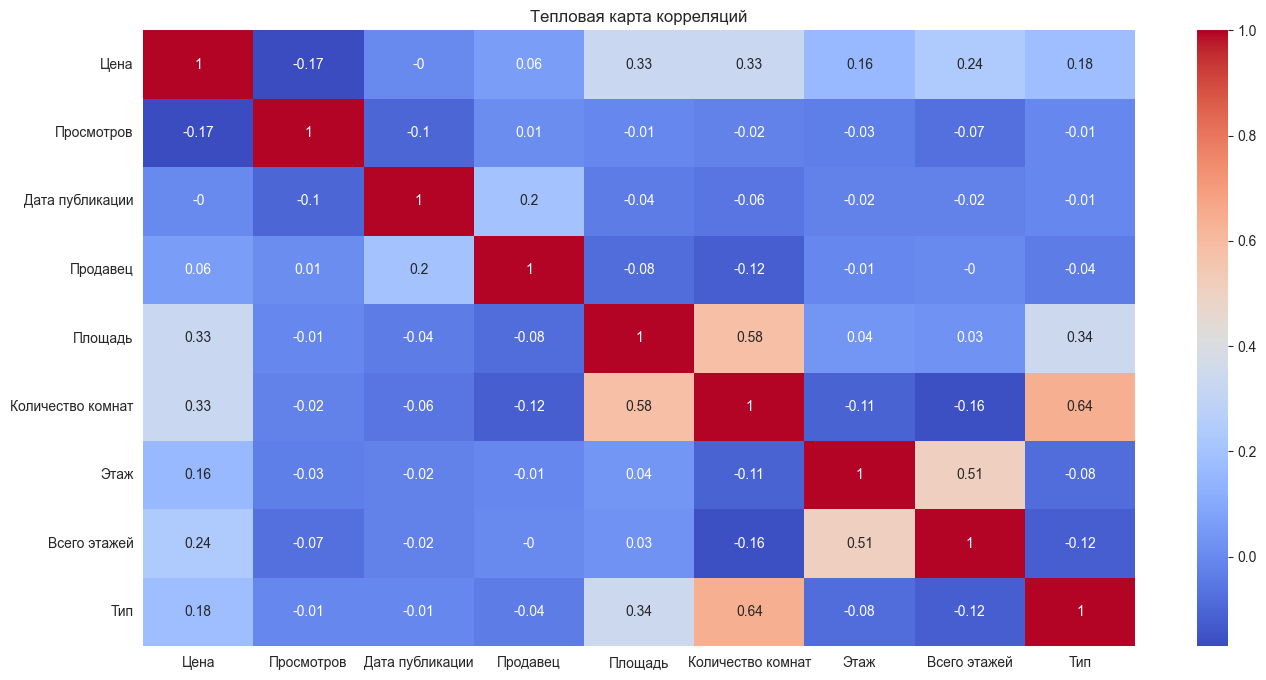

In [108]:
df_cor = df_Rostov.copy()
df_cor.drop(columns=['Номер дома', 'Улица', 'Район'], inplace=True)

plt.figure(figsize=(16,8))
sns.heatmap(data= df_cor.corr(method = 'kendall').round(2), annot= True, cmap="coolwarm")
plt.title('Tепловая карта корреляций')

C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\3777945388.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= data_filter, x = 'Дата публикации', y = 'Цена', palette='pastel')


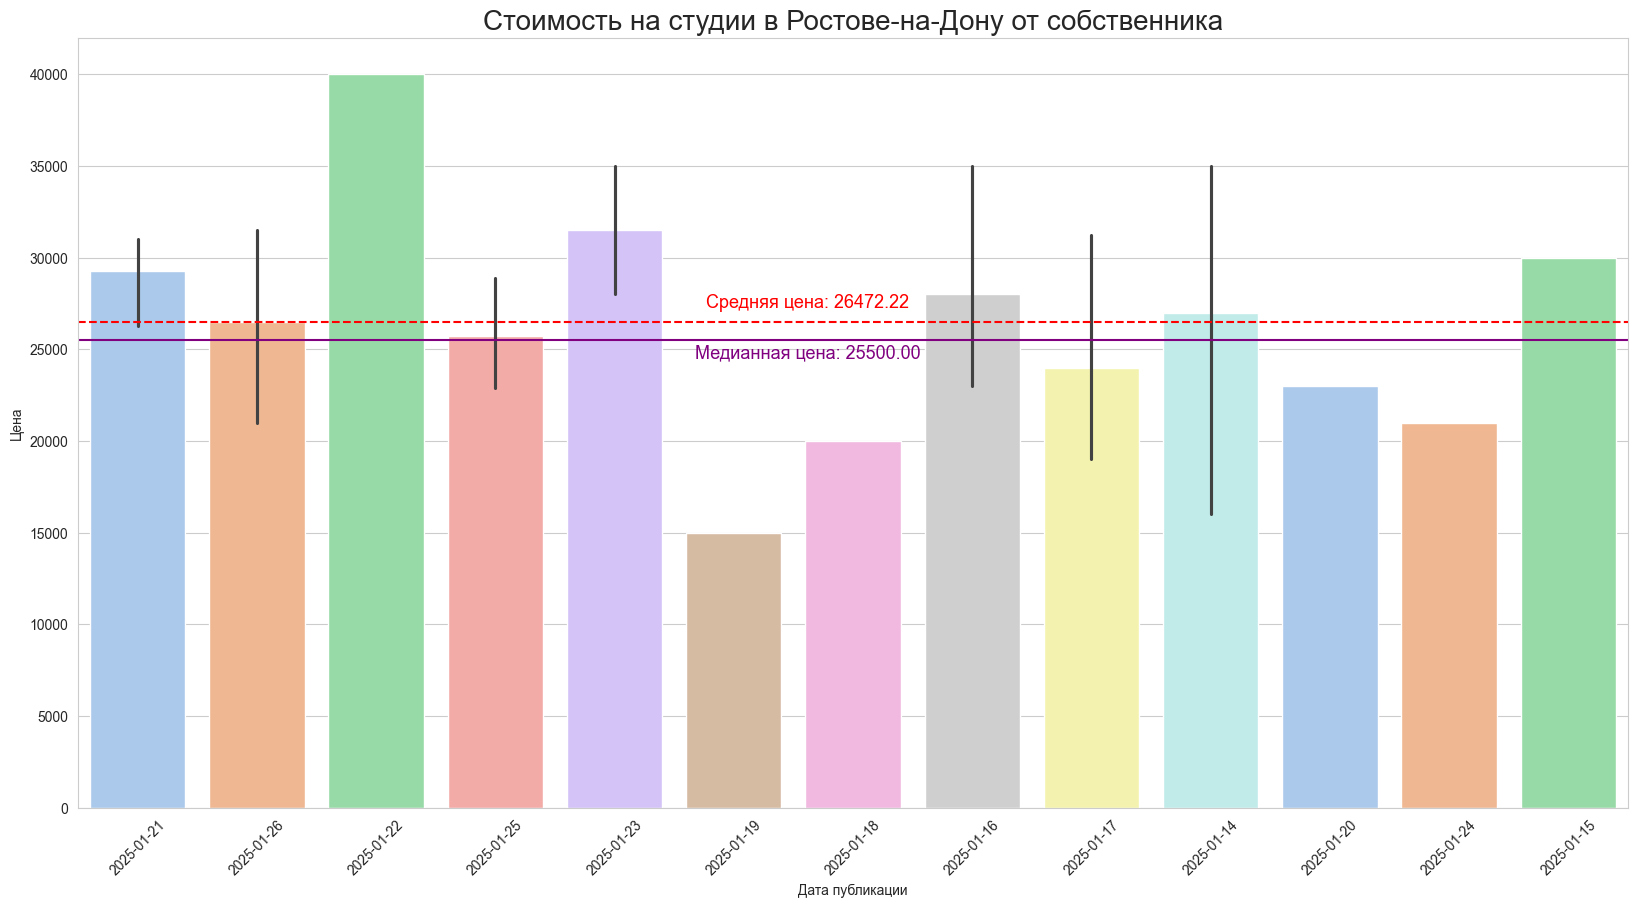

In [109]:
# Столбчатая диаграмма y =цен, x = дата сгрупированных по типу 'Студия' продавец 'Арендадатель'
data_filter = df_Rostov.loc[(df_Rostov['Тип'] == 0) & (df_Rostov['Продавец'] == 1), ['Цена', 'Дата публикации']] 

mean_price = np.mean(data_filter['Цена'])
median_price = np.median(data_filter['Цена'])

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
sns.barplot(data= data_filter, x = 'Дата публикации', y = 'Цена', palette='pastel')
plt.axhline(mean_price, linestyle = '--', color = 'red')
plt.axhline(median_price, linestyle = '-', color = 'purple')
plt.title('Стоимость на студии в Ростове-на-Дону от собственника',fontsize=20)
plt.figtext(0.49, 0.61, f"Средняя цена: {mean_price:.2f}", color='red', fontsize=13, ha='center')
plt.figtext(0.49, 0.56, f"Медианная цена: {median_price:.2f}", color='purple', fontsize=13, ha='center')
plt.xticks(rotation=45)
plt.show()

In [110]:
df_Rostov.loc[(df_Rostov['Тип'] == 0) & (df_Rostov['Продавец'] == 1)].mode()

,Цена,Просмотров,Дата публикации,Продавец,Площадь,Количество комнат,Этаж,Всего этажей,Тип,Улица,Номер дома,Район
0,30000.0,430.0,2025-01-25,1.0,30.0,0.0,1,18.0,0,ул. нансена,7,октябрьский
1,NaN,NaN,NaT,NaN,NaN,NaN,2,NaN,NaN,<NA>,9,NaN


In [111]:
data_filter = df_Rostov[['Цена', 'Площадь']].sort_values(by='Площадь')

C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\730647897.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data= data_filter, x = 'Площадь', y = 'Цена', palette='pastel')


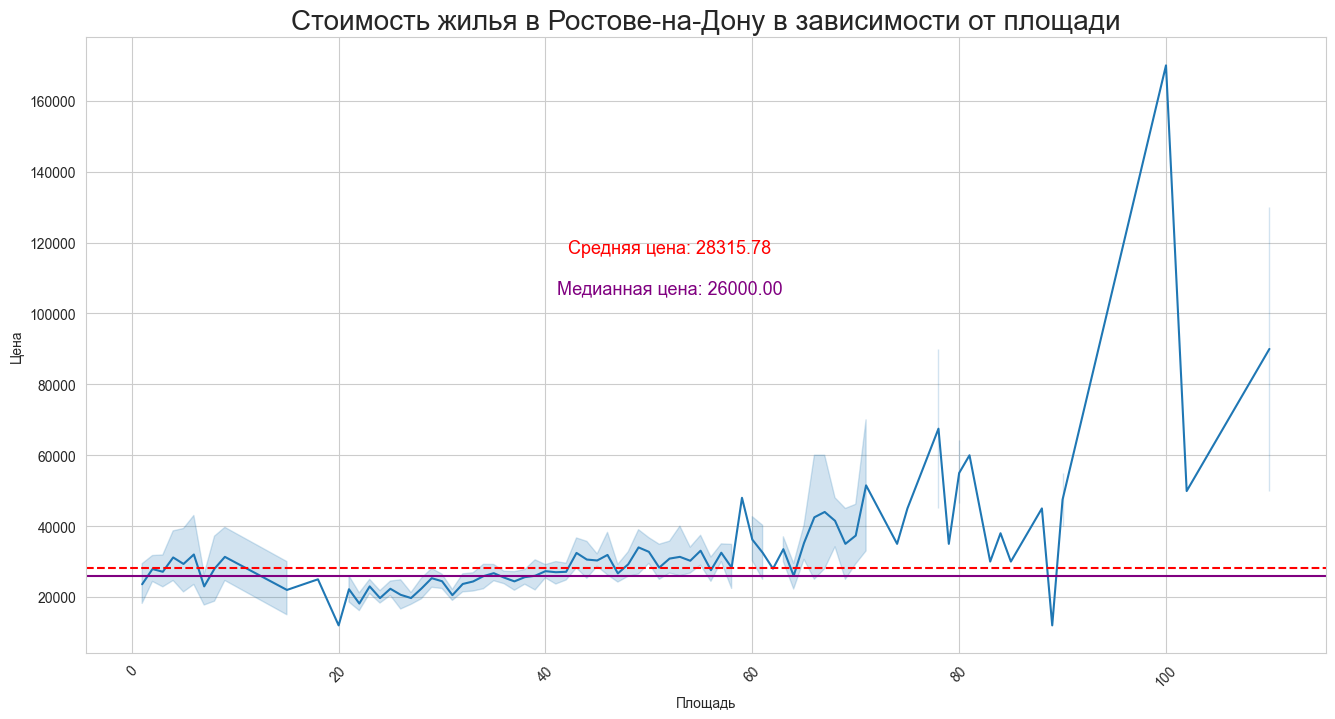

In [112]:
# Столбчатая диаграмма y =цен, x = площадь

mean_price = np.mean(data_filter['Цена'])
median_price = np.median(data_filter['Цена'])

plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
sns.lineplot(data= data_filter, x = 'Площадь', y = 'Цена', palette='pastel')
plt.axhline(mean_price, linestyle = '--', color = 'red')
plt.axhline(median_price, linestyle = '-', color = 'purple')
plt.title('Стоимость жилья в Ростове-на-Дону в зависимости от площади',fontsize=20)
plt.figtext(0.49, 0.61, f"Средняя цена: {mean_price:.2f}", color='red', fontsize=13, ha='center')
plt.figtext(0.49, 0.56, f"Медианная цена: {median_price:.2f}", color='purple', fontsize=13, ha='center')
plt.xticks(rotation=45)
plt.show()

C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\118700952.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data= data_filter, x = 'Площадь', palette='pastel')


<Axes: xlabel='Площадь'>

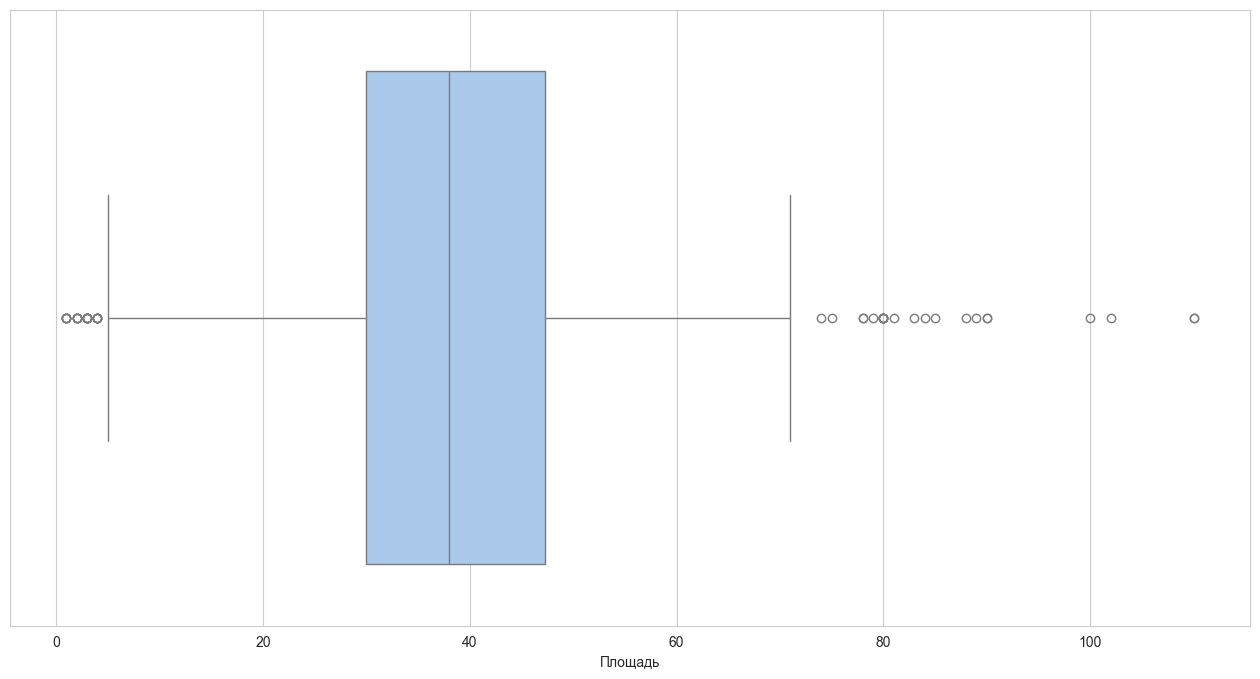

In [113]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
sns.boxplot(data= data_filter, x = 'Площадь', palette='pastel')

C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\4257936927.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data= data_filter, x = 'Цена', palette='pastel')


<Axes: xlabel='Цена'>

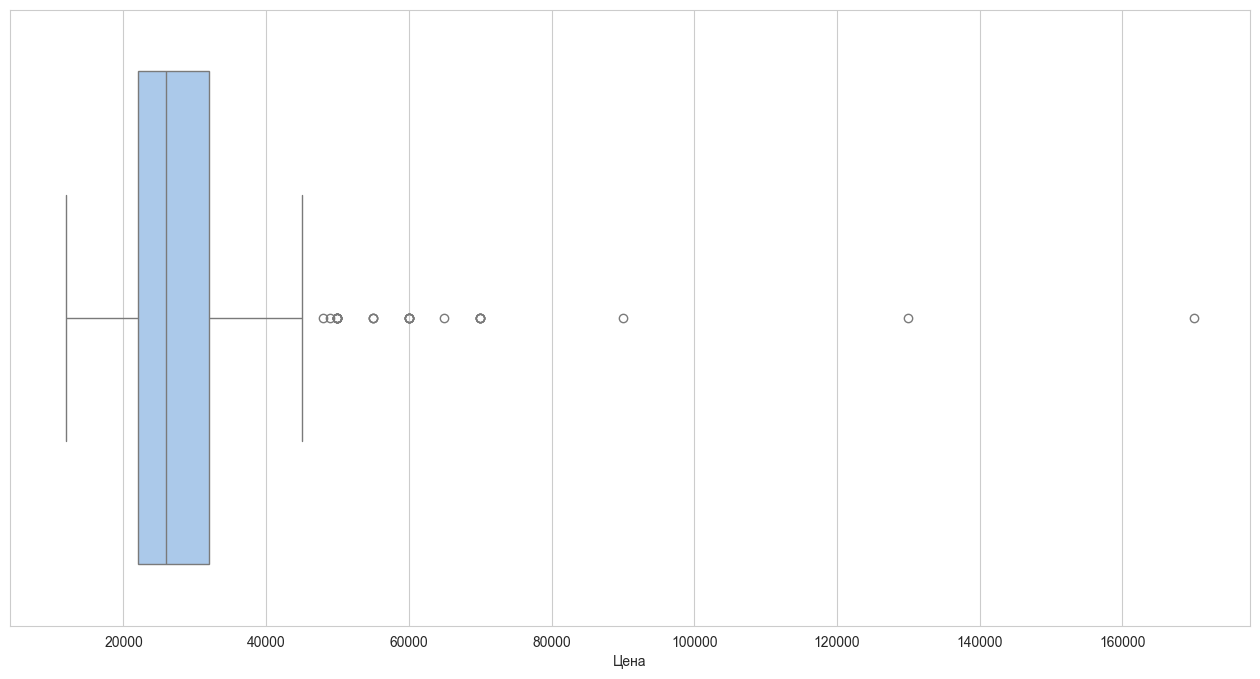

In [114]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
sns.boxplot(data= data_filter, x = 'Цена', palette='pastel')

### Cтандартизация

In [115]:
#Cоздаем датафрейм для стандартизации где нет данных которые нельзя стандартизировать 
df_s = df_Rostov.drop(columns=['Дата публикации', 'Район', 'Улица', 'Номер дома'])

In [116]:
# Производим логарифмирование данных для их сглаживания
list = ['Площадь', "Просмотров", 'Цена']
df_s[list] = np.log1p(df_s[list])

In [117]:
#Cтандартизация
scaler = RobustScaler()

df_scaler = scaler.fit_transform(df_s)
df_scaler = pd.DataFrame(df_scaler, columns= df_s.columns)

C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\1420948107.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data= df_scaler , x = 'Цена', palette='pastel')


<Axes: xlabel='Цена'>

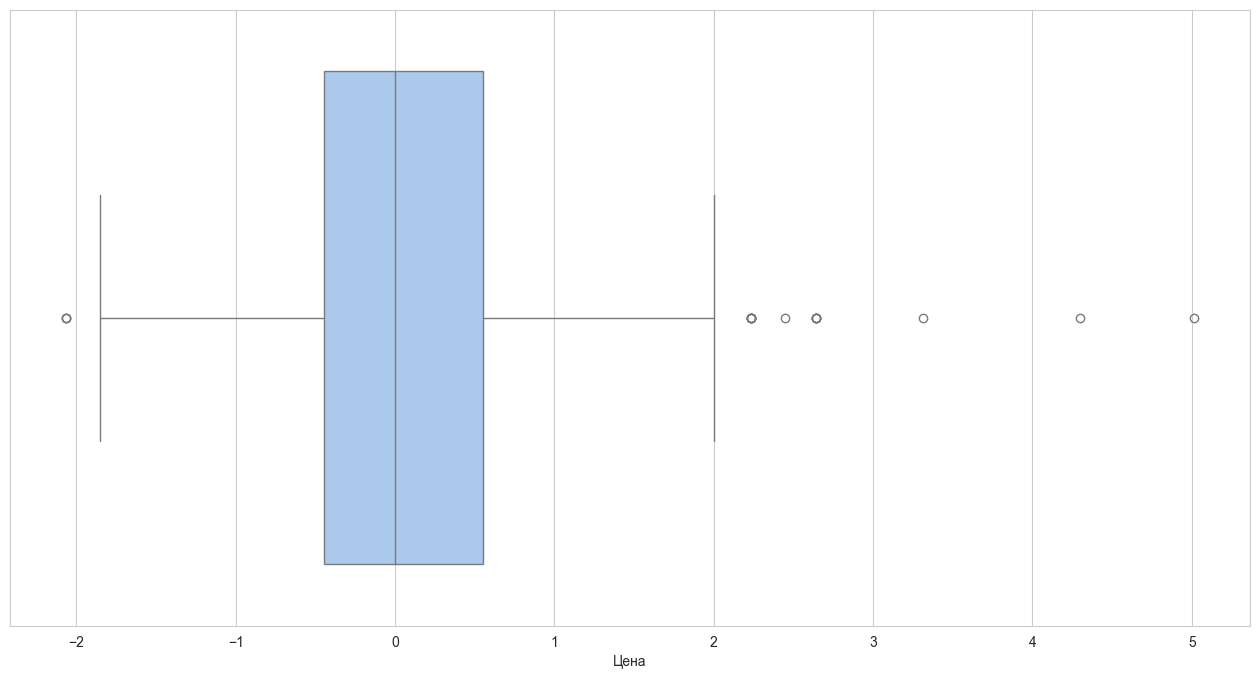

In [118]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
sns.boxplot(data= df_scaler , x = 'Цена', palette='pastel')

C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\1975042520.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data= df_scaler , x = 'Площадь', palette='pastel')


<Axes: xlabel='Площадь'>

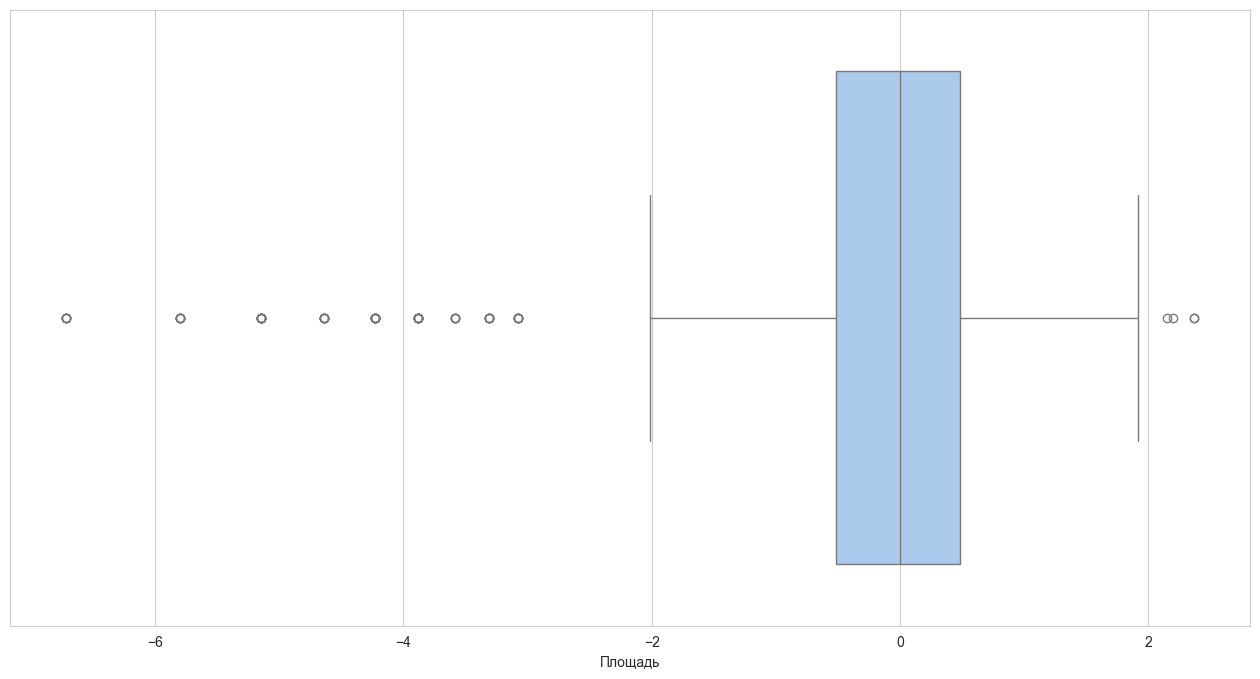

In [119]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
sns.boxplot(data= df_scaler , x = 'Площадь', palette='pastel')

C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\2493459497.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data= df_scaler , x = 'Цена', palette='pastel', kde = True)


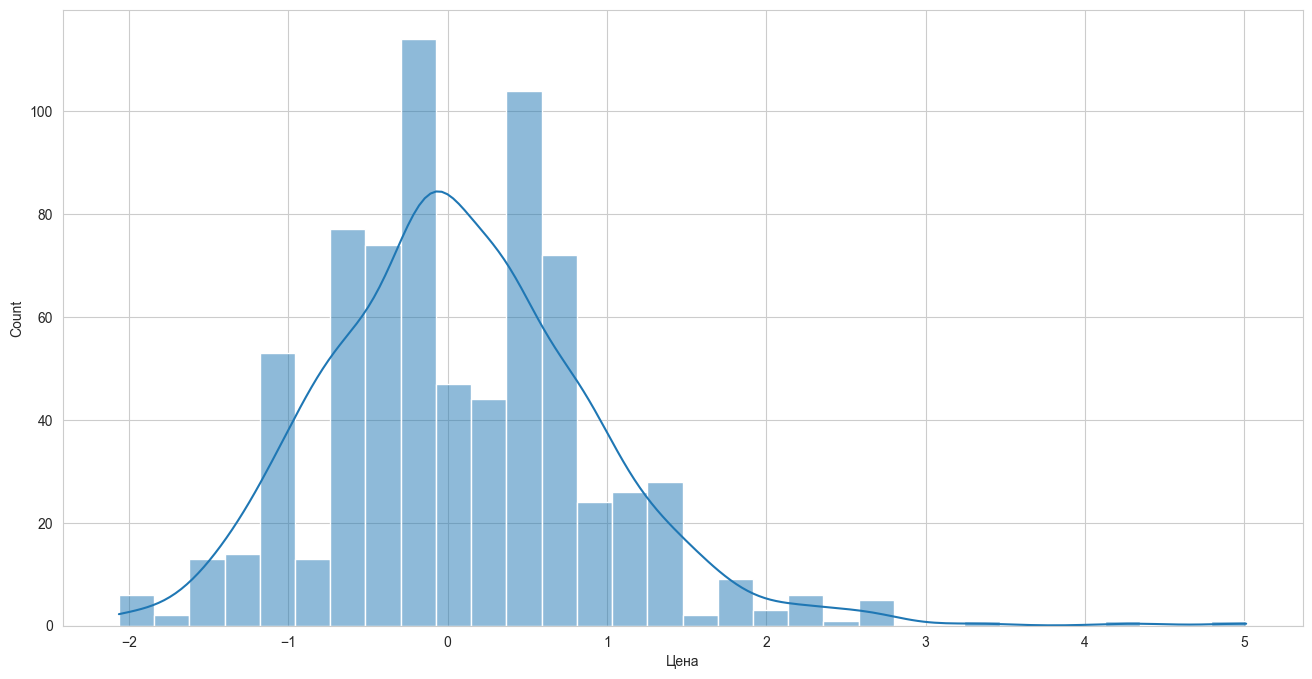

In [120]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
sns.histplot(data= df_scaler , x = 'Цена', palette='pastel', kde = True)
plt.show()

C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\1979936024.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data= df_scaler , x = 'Площадь', palette='pastel', kde = True)


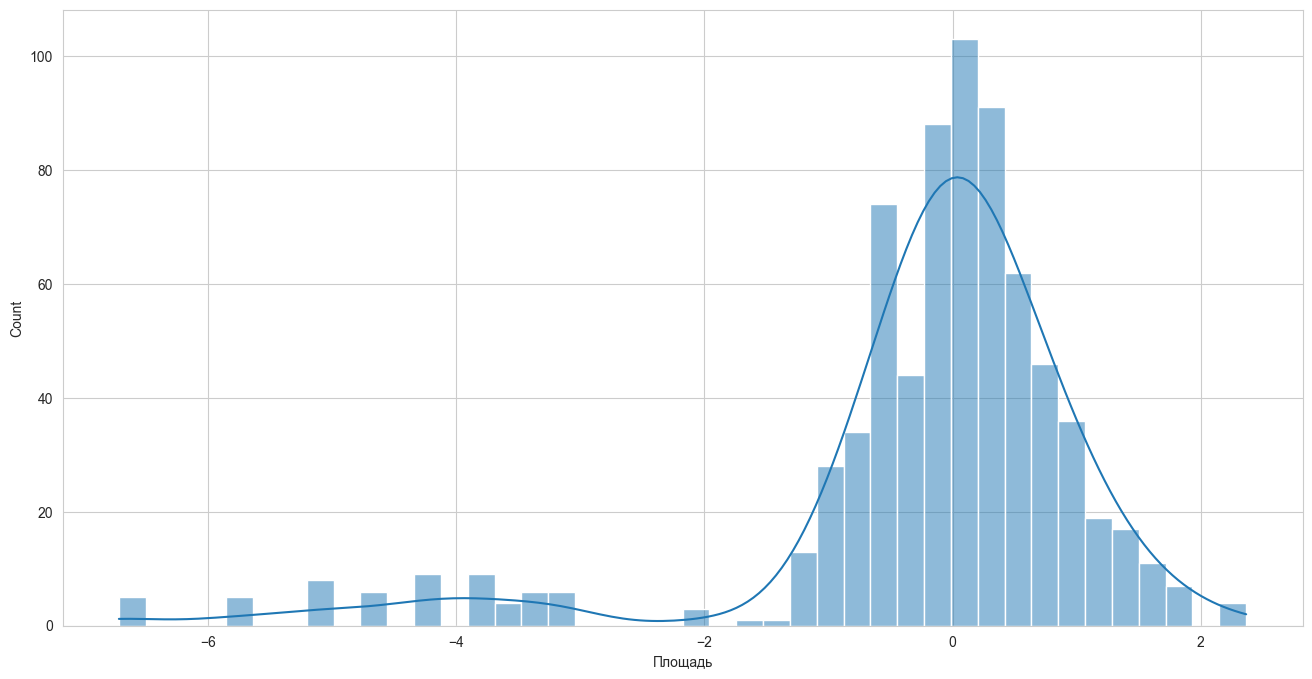

In [121]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
sns.histplot(data= df_scaler , x = 'Площадь', palette='pastel', kde = True)
plt.show()

C:\Users\Александр\AppData\Local\Temp\ipykernel_2344\3396517954.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data= df_scaler , x = 'Просмотров', palette='pastel', kde = True)


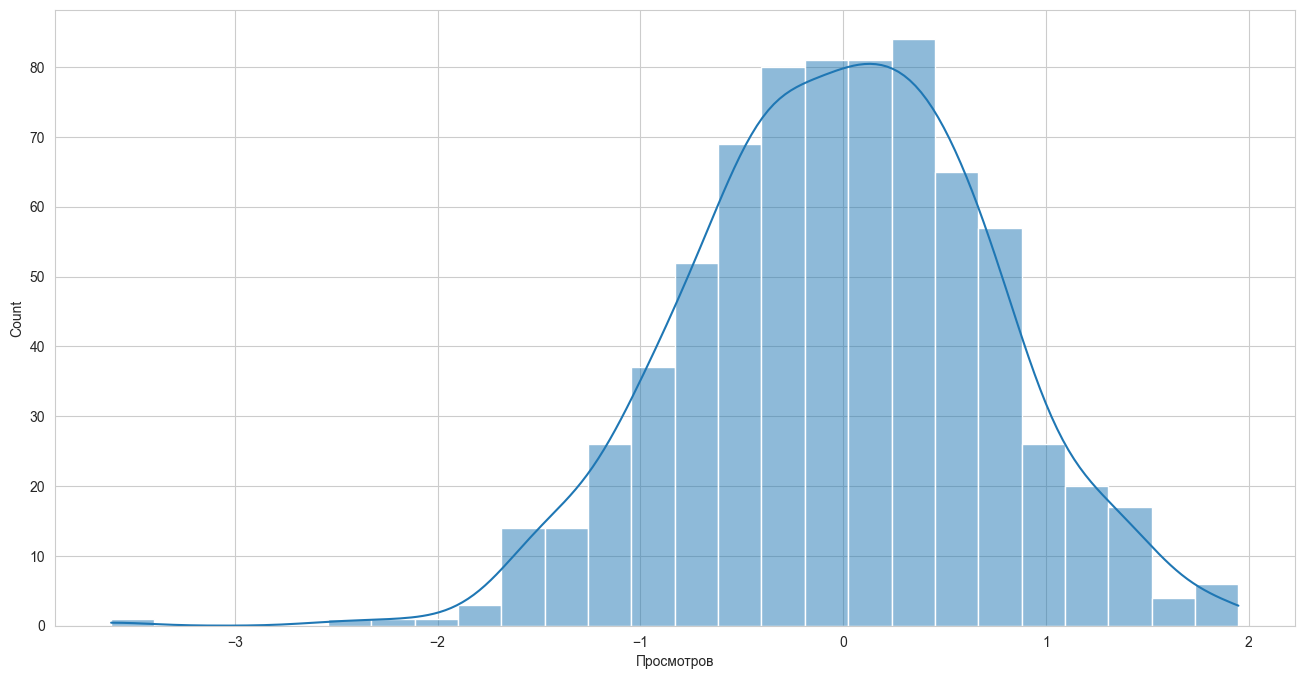

In [122]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
sns.histplot(data= df_scaler , x = 'Просмотров', palette='pastel', kde = True)
plt.show()

### Разделение данных и обучение

In [123]:
#Разделение данных на тестовую и тренировочную выборку
x = df_scaler.drop(columns='Цена')
y = df_scaler['Цена']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val  = train_test_split(x_train, y_train, test_size = 0.125, random_state=42)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(518, 7)
(74, 7)
(148, 7)


In [124]:
# Первая модель для оценки работы с данными и результатами потерь
model = Sequential([
    layers.Dense(256, activation='relu', input_shape = (x_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    
    layers.Dense(1)
])

model.compile(optimizer='adam', loss= 'mse', metrics=['mae'])

model.fit(x_train, y_train, epochs= 100, batch_size= 128, validation_data=(x_val, y_val))

C:\Users\Александр\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - loss: 0.8443 - mae: 1.2580 - val_loss: 0.3201 - val_mae: 0.6464
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.6658 - mae: 1.0590 - val_loss: 0.3215 - val_mae: 0.6516
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.5061 - mae: 0.8857 - val_loss: 0.3183 - val_mae: 0.6477
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4854 - mae: 0.8573 - val_loss: 0.3171 - val_mae: 0.6449
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.4018 - mae: 0.7635 - val_loss: 0.3197 - val_mae: 0.6474
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.4061 - mae: 0.7729 - val_loss: 0.3234 - val_mae: 0.6538
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.3397 - mae: 0.6864 - val_loss: 0.3270 - val_mae: 0.6630
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.3159 - mae: 0.6588 - val_loss: 0.3304 - val_mae: 0.6718
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3360 - mae:

In [125]:
# Модель 2 с ручным подбором слоев и параметров
model2 = Sequential([
    layers.Dense(256, activation='relu', input_shape = (x_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    
    layers.Dense(1)
])

model2.compile(optimizer='adam', loss= 'mse', metrics=['mae'])

model2.fit(x_train, y_train, epochs= 100, batch_size= 128, validation_data=(x_val, y_val))

Epoch 1/100


C:\Users\Александр\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - loss: 1.0262 - mae: 1.4496 - val_loss: 0.3287 - val_mae: 0.6649
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.7644 - mae: 1.1722 - val_loss: 0.3211 - val_mae: 0.6556
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.5586 - mae: 0.9544 - val_loss: 0.3184 - val_mae: 0.6496
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.4904 - mae: 0.8611 - val_loss: 0.3185 - val_mae: 0.6471
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.4558 - mae: 0.8205 - val_loss: 0.3200 - val_mae: 0.6469
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4019 - mae: 0.7608 - val_loss: 0.3221 - val_mae: 0.6476
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.3775 - mae: 0.7328 - val_loss: 0.3246 - val_mae: 0.6503
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3763 - mae: 0.7318 - val_loss: 0.3277 - val_mae: 0.6539
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3744 - mae: 0.7314 - va

In [126]:
# Функция создания модели
def create_model(optimizer='adam', activation='relu', neurons=128):
    model_r_s = Sequential([
    layers.Dense(units = neurons, activation=activation, input_shape = (x_train.shape[1],), 
                 kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    layers.BatchNormalization(),

    layers.Dense(units = int(neurons/2), activation='relu'),
    
    layers.Dense(1, activation = None)
    ])
    model_r_s.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
    return model_r_s
    

In [ ]:
# Нахождение оптимальных гипрепараметров с помощью KerasRegressor
param_dist = {
    'optimizer': ['Adam', 'sgd', 'rmsprop'],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'neurons': [64, 128, 256],
    'batch_size': [8, 16, 32],
    'epochs': [30, 100, 200],
    'random_state': [42, None, 33]
}

model_r_s = KerasRegressor(build_fn=create_model, verbose=0, neurons=128, optimizer='adam', activation='relu')

rand_serch = RandomizedSearchCV(
    estimator = model_r_s,
    param_distributions = param_dist, 
    n_iter= 10, cv =3, verbose=2, random_state=42)

rand_serch_result = rand_serch.fit(x_train, y_train)

In [128]:
print("Лучшие параметры:", rand_serch_result.best_params_, '\n')
print("Лучшая модель:", rand_serch_result.best_estimator_, '\n')
print("Лучшее значение на кросс-валидации:", rand_serch_result.best_score_, '\n')

best_param = rand_serch_result.best_params_

Лучшие параметры: {'random_state': None, 'optimizer': 'sgd', 'neurons': 64, 'epochs': 100, 'batch_size': 16, 'activation': 'tanh'} 

Лучшая модель: KerasRegressor(
	model=None
	build_fn=<function create_model at 0x000001EC58C8B9A0>
	warm_start=False
	random_state=None
	optimizer=sgd
	loss=None
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	neurons=64
	activation=tanh
) 

Лучшее значение на кросс-валидации: 0.3952543465628307 



In [129]:
# Создадим модель на основе расчета гипрепараметров
model3 = Sequential([
    layers.Dense(units=best_param['neurons'], input_shape = (x_train.shape[1],), activation= best_param['activation'],
                 kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    layers.BatchNormalization(),

    layers.Dense(units = int(best_param['neurons']/2), activation= best_param['activation']),
    #layers.BatchNormalization(),

    #layers.Dense(units = int(best_param['neurons']/4), activation= best_param['activation']),
    
    layers.Dense(1, activation= None)
])


model3.compile(optimizer=best_param['optimizer'], loss='mse', metrics=['mae'])

model3.fit(x_train, y_train, batch_size= best_param['batch_size'], 
           epochs= best_param['epochs'], validation_data=(x_val, y_val))

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7883 - mae: 0.6868 - val_loss: 0.5959 - val_mae: 0.5871
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5811 - mae: 0.5855 - val_loss: 0.7175 - val_mae: 0.6420
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4841 - mae: 0.5379 - val_loss: 0.6271 - val_mae: 0.6370
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3926 - mae: 0.5005 - val_loss: 0.5092 - val_mae: 0.5499
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4419 - mae: 0.5194 - val_loss: 0.9451 - val_mae: 0.7752
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4697 - mae: 0.5318 - val_loss: 0.4327 - val_mae: 0.5329
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4875 - mae: 0.5350 - val_loss: 0.4257 - val_mae: 0.5192
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4250 - mae: 0.5108 - val_loss: 0.4790 - val_mae: 0.5380
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


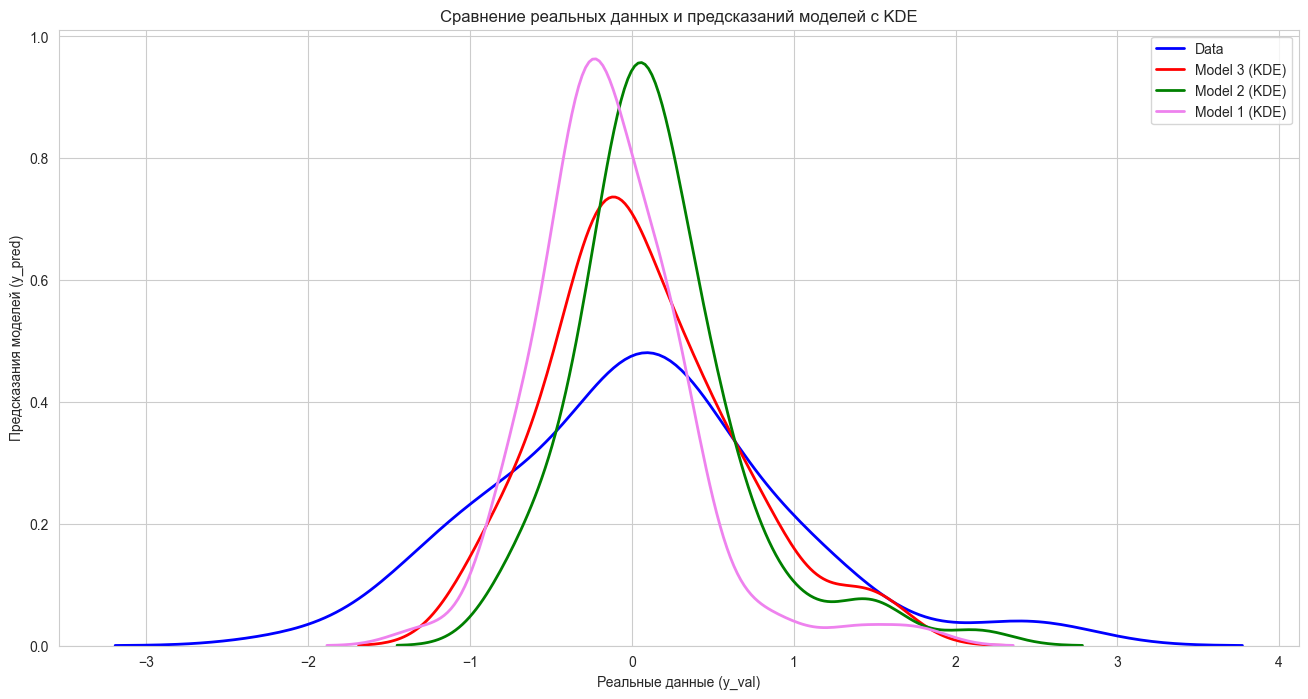

In [130]:
# Визуализауия моделей предсказания и валидационных данных
y_pred3 = model3.predict(x_val)
y_pred2 = model2.predict(x_val)
y_pred1 = model.predict(x_val)

plt.figure(figsize=(16, 8))

sns.kdeplot(y_val, color='blue', label='Data', lw=2)
sns.kdeplot(y_pred3.flatten(), color='red', label='Model 3 (KDE)', lw=2)
sns.kdeplot(y_pred2.flatten(), color='green', label='Model 2 (KDE)', lw=2)
sns.kdeplot(y_pred1.flatten(), color='violet', label='Model 1 (KDE)', lw=2)

plt.xlabel('Реальные данные (y_val)')
plt.ylabel('Предсказания моделей (y_pred)')
plt.title('Сравнение реальных данных и предсказаний моделей с KDE')
plt.legend()

plt.show()


In [136]:
# Вычислим среднеквадратичную ошибку, абсолюдную ошибку, коэф. детерминации /
mae = mean_absolute_error(y_val, y_pred3)
mse = mean_squared_error(y_val, y_pred3)
r2 = r2_score(y_val, y_pred3)

print (f"MAE {mae:.2} \n", f"MSE {mse:.2} \n", f"R2 {r2:.2} \n")

MAE 0.48 
 MSE 0.38 
 R2 0.51 



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


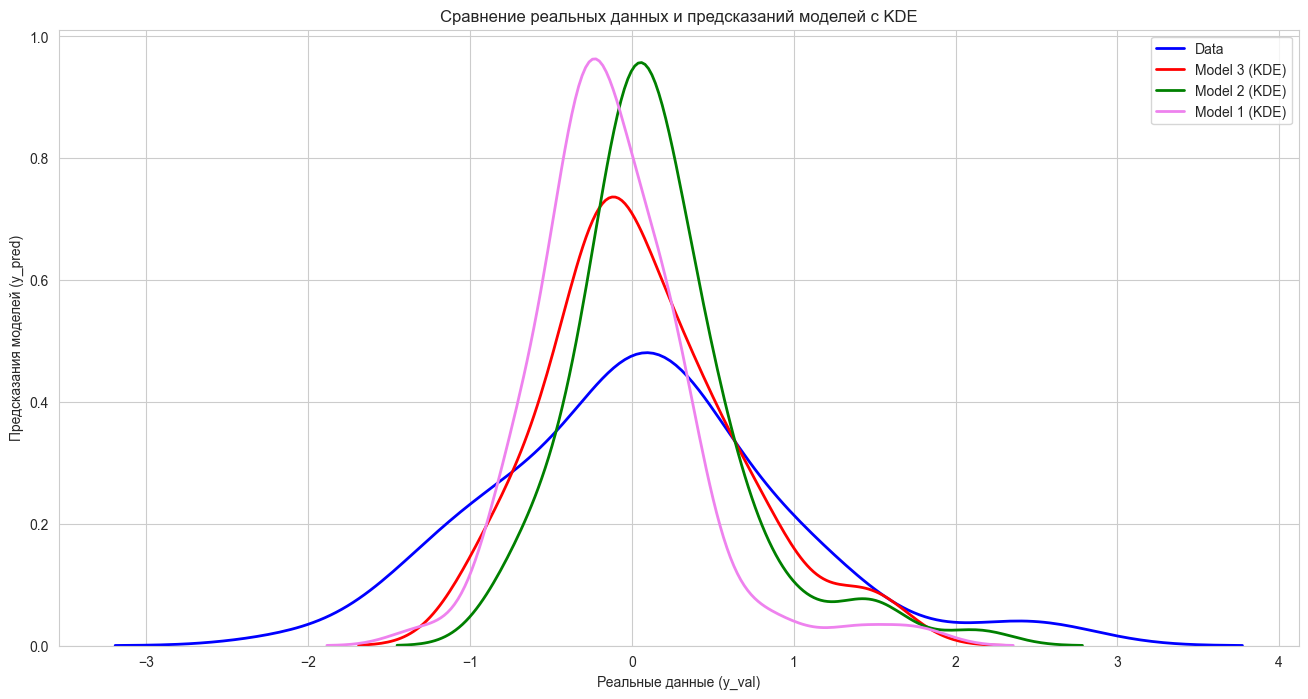

In [132]:
y_pred_test_3 = model3.predict(x_test)
y_pred_test_2 = model2.predict(x_test)
y_pred_test_1 = model.predict(x_test)

plt.figure(figsize=(16, 8))

sns.kdeplot(y_val, color='blue', label='Data', lw=2)
sns.kdeplot(y_pred3.flatten(), color='red', label='Model 3 (KDE)', lw=2)
sns.kdeplot(y_pred2.flatten(), color='green', label='Model 2 (KDE)', lw=2)
sns.kdeplot(y_pred1.flatten(), color='violet', label='Model 1 (KDE)', lw=2)

plt.xlabel('Реальные данные (y_val)')
plt.ylabel('Предсказания моделей (y_pred)')
plt.title('Сравнение реальных данных и предсказаний моделей с KDE')
plt.legend()

plt.show()


In [135]:
# Вычислим среднеквадратичную ошибку, абсолюдную ошибку, коэф. детерминации /
mae = mean_absolute_error(y_test, y_pred_test_3)
mse = mean_squared_error(y_test, y_pred_test_3)
r2 = r2_score(y_test, y_pred_test_3)

print (f"MAE {mae:.2} \n", f"MSE {mse:.2} \n", f"R2 {r2:.2} \n")

MAE 0.47 
 MSE 0.39 
 R2 0.43 



### Конвертация модели (Сохранение и загрузка)

In [ ]:
#Сериализация
model3.save('mlp_model3.h5')